In [140]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [141]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [142]:
# Hyper-parameters 
# input_size = 784 # 28x28
outputs = 1
num_epochs = 2
batch_size = 1000
learning_rate = 0.001

input_size = 3
sequence_length = 10002
hidden_size = 100
num_layers = 1

In [143]:
# Load dataset
df = pd.read_csv("../sim_og.csv")

In [144]:
X = df[['a', 'q', 'delta_e']].values
y = df[['Cd']].values

In [145]:
# Sequential split: 80% train, 10% val, 10% test
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

In [146]:
# Convert to tensors and reshape for RNN input: (batch, sequence, input_size)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
y_val   = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test  = torch.tensor(y_test, dtype=torch.float32).to(device)

In [147]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, outputs):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, outputs)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

In [148]:
model = RNN(input_size, hidden_size, num_layers, outputs).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [149]:
# Initialize loss history
train_losses = []
val_losses = []

actual_epoch = 0
max_epochs = 5000
for epoch in range(max_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    actual_epoch = epoch + 1
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")


Epoch 1000/5000, Train Loss: 5.7992865549749695e-06, Val Loss: 0.0002499813854228705
Epoch 2000/5000, Train Loss: 2.992344889207743e-06, Val Loss: 0.00015798970707692206
Epoch 3000/5000, Train Loss: 1.4821763443251257e-06, Val Loss: 9.694368054624647e-05
Epoch 4000/5000, Train Loss: 6.940899197616091e-07, Val Loss: 6.421272701118141e-05
Epoch 5000/5000, Train Loss: 6.558212248819473e-07, Val Loss: 5.2685449190903455e-05


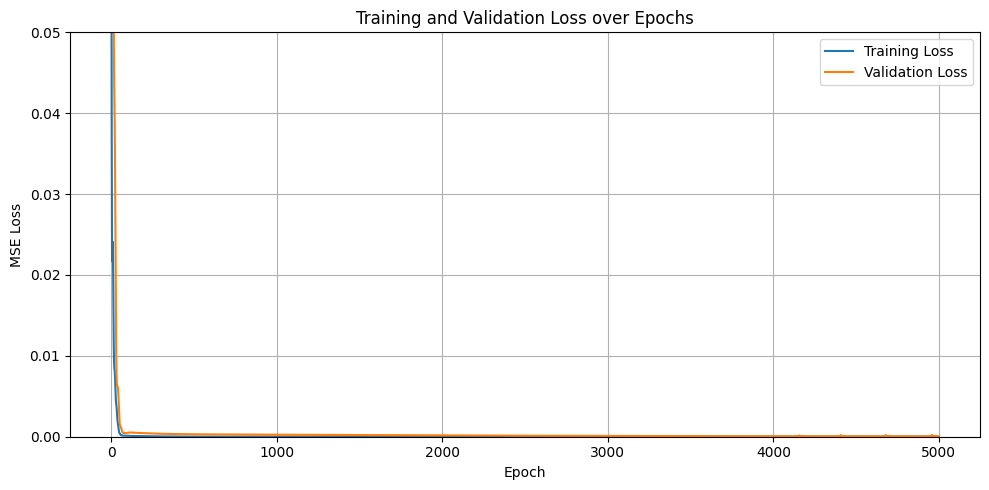

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Dynamically set y-limits based on max of validation loss
plt.ylim(0,0.05)

plt.tight_layout()
plt.show()


In [151]:
# Save the trained model
torch.save(model.state_dict(), "trained_rnn.pth")
print("Model saved as trained_rnn.pth")


Model saved as trained_rnn.pth
